In [73]:
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dropout, MaxPooling2D, UpSampling2D
from keras.optimizers import Adadelta
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from skimage.io import imread
from keras.models import load_model
from keras.callbacks import EarlyStopping


## 1. Read images

In [74]:
TRAIN_IMG_PATH = 'banco_dados_SB/train/imagens/'
TRAIN_LBL_PATH = 'banco_dados_SB/train/classes/'

TEST_IMG_PATH = 'banco_dados_SB/test/imagens/'
TEST_LBL_PATH = 'banco_dados_SB/test/classes/'

In [75]:
X_train = [imread(fname=TRAIN_IMG_PATH + img, as_grey=True) for img in os.listdir(TRAIN_IMG_PATH)]
y_train = [imread(fname=TRAIN_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TRAIN_LBL_PATH)]

In [76]:
X_train = np.asarray(X_train)/255
y_train = np.asarray(y_train)

In [77]:
X_test = [imread(fname=TEST_IMG_PATH + img, as_grey=True) for img in os.listdir(TEST_IMG_PATH)]
y_test = [imread(fname=TEST_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TEST_LBL_PATH)]

In [78]:
X_test = np.asarray(X_test)/255
y_test = np.asarray(y_test)

### Testing data set

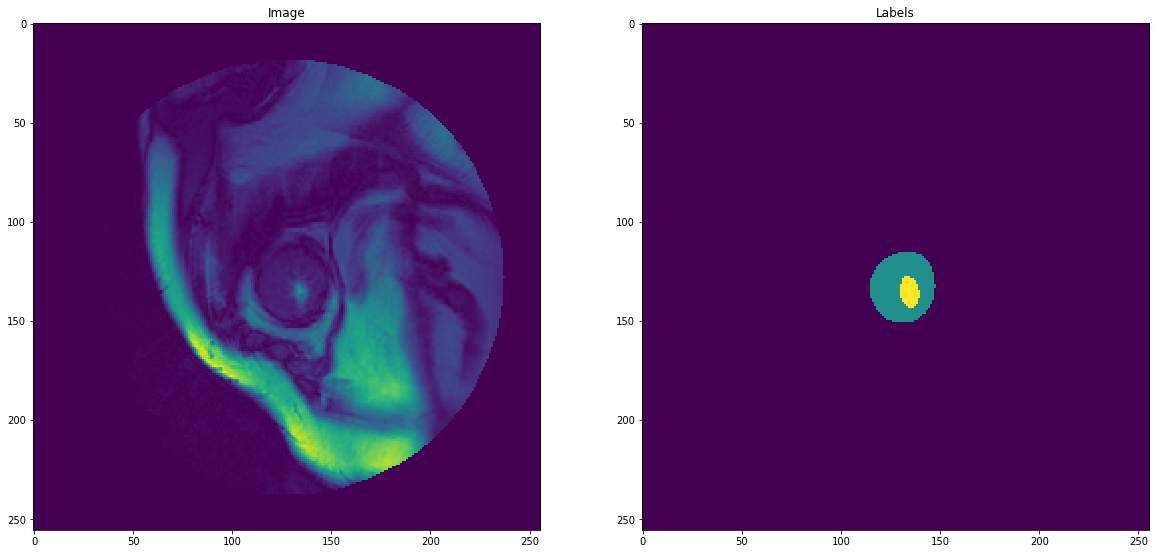

In [79]:
idx = 3

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[idx])
ax[0].set_title('Image')

ax[1].imshow(y_train[idx])
ax[1].set_title('Labels')

plt.show()

## 2. Create CNN model

In [80]:
input_shape = (X_train[0].shape[0], X_train[0].shape[1], 1)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer= 'glorot_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (7, 7), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(512, (7, 7), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(3, (7, 7), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(UpSampling2D(size=(8, 8)))
model.add(Activation(activation='softmax'))

In [81]:
print (input_shape, X_train.shape)
model.summary()

(256, 256, 1) (338, 256, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 25

In [82]:
model.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

## 3. Prepare data

In [83]:
# Reshape input images to fit TensorFlow shape pattern
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [84]:
# One hot encoded label images
y_train_ohe = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], 3))
y_test_ohe = np.zeros((y_test.shape[0], y_test.shape[1], y_test.shape[2], 3))

In [85]:
y_train_ohe[:, :, :, 0] = np.where(y_train == 0, 1, 0)
y_train_ohe[:, :, :, 1] = np.where(y_train == 1, 1, 0)
y_train_ohe[:, :, :, 2] = np.where(y_train == 2, 1, 0)

In [86]:
y_test_ohe[:, :, :, 0] = np.where(y_test == 0, 1, 0)
y_test_ohe[:, :, :, 1] = np.where(y_test == 1, 1, 0)
y_test_ohe[:, :, :, 2] = np.where(y_test == 2, 1, 0)

## 4. Train model

In [103]:
from keras.models import load_model
path_sav = 'savings/'
model = load_model(path_sav +'Lis_net.h5')

In [ ]:
batch_size = 25
epochs = 100
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True,batch_size=batch_size)

# Monitorando se a função não esta aprendendo mais...
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test_ohe),
          callbacks=[tbCallBack,early_stopping])

In [ ]:
path_sav = 'savings/'
model.save(path_sav +'Lis_net.h5')

In [ ]:
P_fig = model.predict(X_test, batch_size=batch_size, verbose=1)

In [ ]:
ch0_arr = np.asarray (P_fig[:,:,:,0])
ch1_arr = np.asarray (P_fig[:,:,:,1])
ch2_arr = np.asarray (P_fig[:,:,:,2])
ch_shape = ch0_arr.shape
print(ch_shape)

In [ ]:
ch0_arr = np.reshape(ch0_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])
ch1_arr = np.reshape(ch1_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])
ch2_arr = np.reshape(ch2_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])

In [ ]:
im_final = np.zeros(ch0_arr.shape)
for ii in np.arange(len(ch0_arr)):
    if ch0_arr[ii]>ch1_arr[ii] and ch0_arr[ii]>ch2_arr[ii]:
        im_final[ii] = 0
    elif ch1_arr[ii]>ch0_arr[ii] and ch1_arr[ii]>ch2_arr[ii]:
        im_final[ii] = 1
    else:
        im_final[ii] = 2
im_final = np.reshape(im_final,ch_shape)

In [ ]:
idx = 9

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(X_test[idx,:,:,0])
ax[0].set_title('Imagem teste')

ax[1].imshow(im_final[idx,:,:])
ax[1].set_title('Imagem final')

In [ ]:
sess = tf.Session()
writer = tf.summary.FileWriter("Graph")
writer.add_graph (sess.graph)
sess.close()